In [93]:
import sklearn
import numpy as np
import pandas as pd
import lime

from lime import lime_tabular
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

np.random.seed(1)

import warnings
warnings.filterwarnings("ignore")


## Full Example Using a Pipe

In [94]:
fake_data = pd.read_csv('../data/generated_data_numpy.csv')

original_data = fake_data.copy()
fake_data = fake_data.drop(columns=['Policy_Id', 'Policy_Year', 'Policy_Month'])
fake_data['Accident_Reported'] = np.where(fake_data['Accident_Reported'] == 1, 'Accident', 'No Accident')


In [95]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(
    fake_data[[x for x in fake_data.columns if x != 'Accident_Reported']],
    fake_data['Accident_Reported'],
    train_size=0.80)

train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [96]:
# get a list of categorical features
categorical_features = ['Make', 'Body_Style', 'Model_Color', 'Driver_Hair_Color']

# get a list of numeric features
numeric_features = [x for x in fake_data.columns if x not in categorical_features]


In [97]:
# get categorical features idx
categorical_features_idx = list(np.where(np.isin(train.columns, categorical_features))[0])

# get numeric features idx
numeric_features_idx = list(np.where(np.isin(train.columns, numeric_features))[0])


In [98]:
print(categorical_features_idx)

[0, 1, 3, 5]


We have to convert text to numbers for LimeExplainer to work unfortunately...

In [99]:
# Encode categorical features using LabelEncoder
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    train[feature] = label_encoders[feature].fit_transform(train[feature])
    

In [100]:
# use the label encoders to encode the test data
for feature in categorical_features:
    test[feature] = label_encoders[feature].transform(test[feature])


Let's go ahead and store the label encoded values so that we can have the proper names in the lime explainer.

In [101]:
categorical_values = {}
for feature in categorical_features:
    # get column number
    col_num = train.columns.get_loc(feature)
    categorical_values[col_num] = list(label_encoders[feature].classes_)

categorical_values


{0: ['Honda', 'Subaru', 'Toyota'],
 1: ['sedan', 'suv', 'truck'],
 3: ['Blue', 'Red', 'White'],
 5: ['Black', 'Brown']}

We build a quick pipeline model to use for evaluating the method

In [102]:
# build a numeric transformer 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())], 
    verbose=True)

# build a categorical transformer with simple imputer and one hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))], 
    verbose=True)

# build a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_idx),
        ('cat', categorical_transformer, categorical_features_idx)])

# build a classifier
clf = RandomForestClassifier(n_estimators=100)

# build a pipeline to apply the preprocessing and the classifier
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', clf)])


In [103]:
# fit the pipeline
pipe.fit(train.to_numpy(), labels_train)


[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   0.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  [2, 4, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))],
                                                           verbose=True),
                                                  [0, 1, 3, 5])])),
                ('classifier', RandomForestClassifier())])

In [104]:
train

,Make,Body_Style,Model_Year,Model_Color,Miles_Driven,Driver_Hair_Color,Years_Customer
2694,2,0,2018,0,7405,1,8
5140,0,0,2006,2,24593,1,17
2568,2,0,2013,0,24721,1,18
3671,2,1,2008,2,10010,0,20
7427,1,0,2020,1,21458,0,13
...,...,...,...,...,...,...,...
2895,2,2,2019,0,1387,1,9
7813,0,0,2002,2,18990,1,14
905,1,1,2006,1,9452,1,5
5192,2,1,2000,1,17542,1,4


In [105]:
# evaluate the pipeline on the test set
roc_auc_score(labels_test, pipe.predict_proba(test.to_numpy())[:, 1])


0.7972861016268327

In [106]:
# evaluate accuracy of the pipeline on the test set
pipe.score(test.to_numpy(), labels_test)


0.784

In [107]:
# build an explainer for the pipeline
explainer = lime_tabular.LimeTabularExplainer(train.values,
                                              feature_names=train.columns,
                                              categorical_features=categorical_features_idx,
                                              categorical_names=categorical_values,
                                              mode='classification',
                                              class_names=clf.classes_,
                                              discretize_continuous=True,
                                              sample_around_instance=True)


In [108]:
def peek(x):        
    test_instance = test.iloc[x].copy()
    for feature in categorical_features:
        test_instance[feature] = label_encoders[feature].inverse_transform([test_instance[feature]])[0]
    # add labels_test to test_instance
    test_instance['Risk'] = labels_test.iloc[x]
    return test_instance

test_num = 0
peek(test_num)

Make                       Honda
Body_Style                   suv
Model_Year                  2002
Model_Color                  Red
Miles_Driven                8977
Driver_Hair_Color          Brown
Years_Customer                17
Risk                 No Accident
Name: 9953, dtype: object

In [109]:
# explain the first instance in the test set
exp = explainer.explain_instance(test.values[test_num], pipe.predict_proba, num_features=7)
exp.show_in_notebook(show_table=True, show_all=True)


In [110]:
# sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

# calculate the "actual" probability based on these features
print(f"Actual: {sigmoid((17685-10000)/5000)}")

# calculate our local interpretable model's probability
print(f"Local: {sigmoid(np.exp(0.1)*np.exp(0.2))}")

Actual: 0.8230281902226513
Local: 0.794106544007046


In [111]:
perturbed_labels, perturbed_data = explainer._LimeTabularExplainer__data_inverse(test.values[test_num], 1000)
perturbed = pd.DataFrame(perturbed_data, columns=test.columns)
perturbed.head()

,Make,Body_Style,Model_Year,Model_Color,Miles_Driven,Driver_Hair_Color,Years_Customer
0,0.0,1.0,2002.000000,1.0,8977.000000,1.0,17.000000
1,1.0,0.0,2014.316185,2.0,21576.937980,0.0,18.964818
2,0.0,1.0,2022.699016,1.0,5890.225210,0.0,19.135059
3,2.0,1.0,2000.761036,1.0,4515.253258,1.0,13.240497
4,1.0,2.0,2020.058313,1.0,10177.552280,0.0,15.092915


Trying another instance.

In [112]:
test_num = 1000
accident_test = test.iloc[test_num].values
peek(test_num)

Make                      Subaru
Body_Style                   suv
Model_Year                  2005
Model_Color                  Red
Miles_Driven               23828
Driver_Hair_Color          Brown
Years_Customer                15
Risk                 No Accident
Name: 3376, dtype: object

In [113]:
# store an example for exploration
example = test[test_num:(test_num + 1)]

# predict the example
reported_prob = lambda x: pipe.predict_proba(x.to_numpy())[0][1]

# verify we get the same probability as above
reported_prob(example)


0.92

In [114]:
exp = explainer.explain_instance(example.values[0], pipe.predict_proba, num_features=7)
exp.show_in_notebook(show_table=True, show_all=True)

In [115]:
exp.as_list()

[('Miles_Driven > 18963.75', -0.1976309053506186),
 ('10.00 < Years_Customer <= 15.00', 0.1769521465684802),
 ('Body_Style=suv', 0.03416333399330525),
 ('Model_Color=Red', 0.03108199890365537),
 ('Make=Subaru', 0.02119701503025193),
 ('Driver_Hair_Color=Brown', -0.021046041901419895),
 ('Model_Year <= 2006.00', 0.001419627455535566)]

Let's try perturbing this a bit and see how it changes. Based on the above, let's try adjusting the Years_Customer.

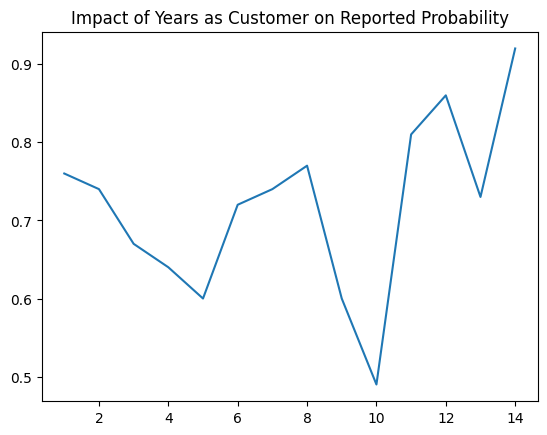

In [116]:
impact = {}
for years in range(1, 15):
    example.loc[:, "Years_Customer"] = years
    impact[years] = reported_prob(example)

pd.DataFrame(impact, index=["Reported Probability"]).T.plot(legend=False, 
                                                            title="Impact of Years as Customer on Reported Probability")
plt.show()


In [117]:
perturbed_labels, perturbed_data = explainer._LimeTabularExplainer__data_inverse(test.values[test_num], 10000)
perturbed = pd.DataFrame(perturbed_data, columns=test.columns)
perturbed.head()

,Make,Body_Style,Model_Year,Model_Color,Miles_Driven,Driver_Hair_Color,Years_Customer
0,1.0,1.0,2005.000000,1.0,23828.000000,1.0,14.000000
1,2.0,0.0,2021.347108,1.0,11869.774472,0.0,2.217827
2,2.0,1.0,2003.329759,1.0,12083.677900,1.0,8.786845
3,2.0,0.0,2008.430018,0.0,16081.903950,1.0,7.849863
4,0.0,2.0,2006.115225,0.0,14952.551123,1.0,17.749636


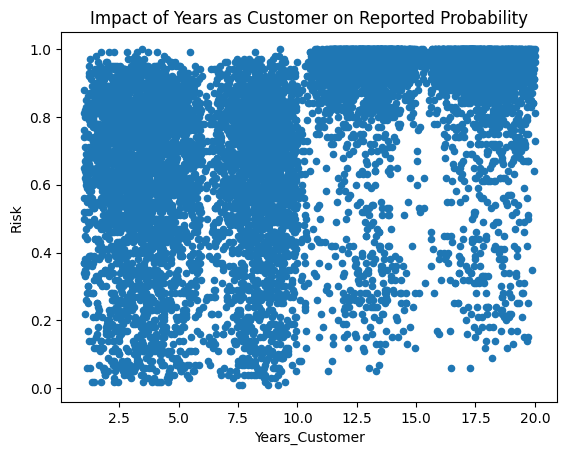

In [118]:
perturbed = pd.DataFrame(perturbed_data, columns=test.columns)
perturbed_predictions = pipe.predict_proba(perturbed)
perturbed_predictions = perturbed_predictions[:, 1]
perturbed["Risk"] = perturbed_predictions

# plot years customer by risk
perturbed.plot.scatter(x="Years_Customer", y="Risk", title="Impact of Years as Customer on Reported Probability")
# add line of best fit
# plt.plot(np.unique(perturbed["Years_Customer"]), np.poly1d(np.polyfit(perturbed["Years_Customer"], perturbed["Risk"], 1))(np.unique(perturbed["Years_Customer"])), color='red')
plt.show()

### Everything below here is just getting explanations for the whole test set

Here, we generate predictions along with our explanations of those predictions.

In [119]:
predictions = pipe.predict_proba(test)
# # get just the second column
predictions = predictions[:, 1]

In [120]:
original_test_data = original_data[original_data.index.isin(test.index)]
original_test_data.loc[test.index, 'Predictions'] = predictions
original_test_data

,Policy_Id,Policy_Year,Policy_Month,Make,Body_Style,Model_Year,Model_Color,Miles_Driven,Driver_Hair_Color,Years_Customer,Accident_Reported,Predictions
6,7,2023,May,Honda,sedan,2021,White,3155,Brown,17,0,0.95
7,8,2023,Dec,Subaru,truck,2014,White,24868,Black,16,0,0.40
21,22,2013,Mar,Honda,suv,2011,Red,2740,Black,17,0,1.00
28,29,2004,Oct,Honda,suv,2017,Red,19846,Black,17,0,0.97
32,33,2008,Jun,Honda,sedan,2001,White,11998,Black,1,1,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...
9979,9980,2004,Dec,Subaru,sedan,2003,Red,19950,Brown,6,0,0.69
9981,9982,2004,Dec,Honda,suv,2005,White,5062,Brown,19,0,0.91
9982,9983,2016,Jul,Subaru,truck,2018,White,23406,Brown,17,0,0.20
9984,9985,2022,Mar,Honda,truck,2014,White,8937,Black,4,0,0.85


In [121]:
def explain_instance(row_number=0):
    exp = explainer.explain_instance(test.iloc[row_number], pipe.predict_proba, num_features=7)
    el = exp.as_list()
    # convert el to a dataframe
    el = pd.DataFrame(el, columns=['feature', 'weight'])
    if labels_test.iloc[row_number] == 0:
        el = el.loc[el.weight < 0]
    else:
        el = el.loc[el.weight > 0]
    el["abs_weight"] = el["weight"].abs()
    el = el.sort_values(by='abs_weight', ascending=False)
    el["Policy_Id"] = original_test_data.iloc[row_number]["Policy_Id"]
    return el.head(3)

In [122]:
# explain all instances and store them in a pandas dataframe
# explanations = []
# for i in range(0, len(test)):s
#     explanations.append(explain_instance(i))

# explanations = pd.concat(explanations)

In [123]:
# explanations.to_csv("../data/explanations.csv", index=False)